In [25]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import sys
from tqdm.notebook import trange
from loguru import logger

# sys.path.append('..')
# from training.src.data_processing import tfrecords as tfr
import training.src.data_processing.tfrecords as tfr

In [26]:
root = Path.cwd().parent
data = root / 'training' / 'data'
tfrec = data / 'tfrec'

In [52]:
df = pd.read_csv(data / 'train.csv')

In [56]:
df['longitude'] = df.groupby('class_id')['longitude'].transform(lambda x: x.fillna(x.median()))
df['latitude'] = df.groupby('class_id')['latitude'].transform(lambda x: x.fillna(x.median()))

In [57]:
df['family'] = df['family'].fillna(r'NA')
df['order'] = df['order'].fillna(r'NA')

In [31]:
df.iloc[2909]

kingdom                                                             Fungi
name                              Sirococcus clavigignenti-juglandacearum
family                                                                 NA
supercategory                                                       Fungi
phylum                                                         Ascomycota
order                                                        Diaporthales
genus                                                          Sirococcus
class                                                     Sordariomycetes
license                                                                 3
file_name                            cc932493a2a456ffb4c9d69407bc267e.jpg
rights_holder                                                 owenclarkin
height                                                                800
width                                                                 600
location_uncertainty                  

In [30]:
df = df.fillna('NA')

In [58]:
df['image_dir'] = df.apply(lambda x: f"{x['kingdom']}_{x['phylum']}_{x['class']}_{x['order']}_{x['family']}_{x['genus']}_{x['specific_epithet']}", axis=1)
df['file_path'] = df.apply(lambda x: f"{data}/train/{x['image_dir']}/{x['file_name']}", axis=1)

In [10]:
df.to_csv(data / 'train.csv', index=False)

In [16]:
df.value_counts(['height', 'width']).head(10)

height  width
500     375      33150
375     500      25808
333     500       6194
500     281       4036
281     500       3142
500     500       2595
600     800       2433
800     600       1744
500     333       1004
334     500        927
Name: count, dtype: int64

In [33]:
df.isna().sum()

kingdom                 0
name                    0
family                  0
supercategory           0
phylum                  0
order                   0
genus                   0
class                   0
license                 0
file_name               0
rights_holder           0
height                  0
width                   0
location_uncertainty    0
date                    0
valid                   0
user_id                 0
latitude                0
longitude               0
dset                    0
dataset                 0
file_path               0
specific_epithet        0
image_dir_name          0
image_id                0
class_id                0
gcs_path                0
class_priors            0
image_dir               0
dtype: int64

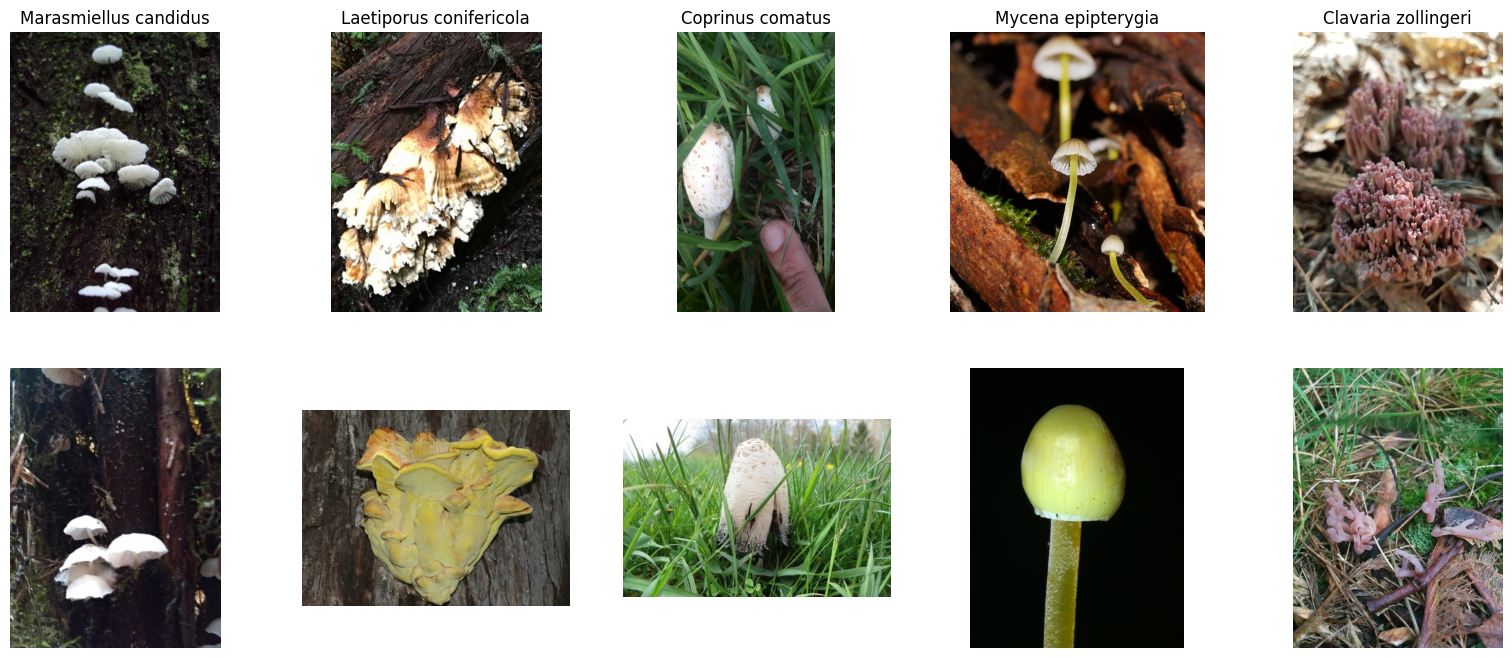

In [47]:
plt.figure(figsize=(20, 8))
classes = df['name'].sort_values().sample(5)
for i, cls in enumerate(classes, start=1):
    imgs = df[df['name'] == cls].sample(2)['file_path']
    for j, img in enumerate(imgs):
        im = cv2.imread(str(img))
        im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        plt.subplot(2, 5, i + (j * 5))
        if j == 0:
            plt.gca().set_title(cls)
        plt.axis('off')
        plt.imshow(im)

In [59]:
df = df.sample(frac=1).sample(frac=1).reset_index(drop=True)

In [60]:
num_train_records = 199
IMGS = df['file_path'].to_list()
SIZE = len(IMGS) // num_train_records
CT = len(IMGS) // SIZE + int(len(IMGS) % SIZE != 0)

In [62]:
# iterate over the number of tfrecords
for j in trange(CT):
    logger.info(f"Writing {j:02d} of {CT} tfrecords")
    CT2 = min(
        SIZE, len(IMGS) - j * SIZE
    )  # get the number of images in a tfrecord

    # create the path to write the tfrecord to
    path = tfrec / "tfrecords-jpeg-raw"
    path.mkdir(parents=True, exist_ok=True)

    with tf.io.TFRecordWriter(
        str(path / f"train{j:02d}-{CT2}.tfrec")
    ) as writer:

        # Iterate through the rows of the dataframe
        for k in trange(CT2, leave=False):
            # if k % 100 == 0:
                # logger.info(f"Writing {k:02d} of {CT2} train tfrecord images")
            row = df.iloc[SIZE * j + k]
            # load image from disk, change RGB to cv2 default BGR format, resize to reshape_sizes and encode as jpeg
            img = cv2.imread(row.file_path)
            img = cv2.imencode(".jpg", img)[1].tobytes()

            # Serialize data
            example = tfr.serialize_example(
                img,
                row.file_name.split(".")[0].encode('utf8'),
                row.longitude,
                row.latitude,
                row.date.encode('utf8'),
                row.class_priors,
                row.width,
                row.height,
                row.class_id,
            )
            writer.write(example)

  0%|          | 0/200 [00:00<?, ?it/s]

2023-11-18 01:25:30.778 | INFO     | __main__:<module>:3 - Writing 00 of 200 tfrecords


  0%|          | 0/508 [00:00<?, ?it/s]

2023-11-18 01:25:34.827 | INFO     | __main__:<module>:3 - Writing 01 of 200 tfrecords


  0%|          | 0/508 [00:00<?, ?it/s]

2023-11-18 01:25:38.808 | INFO     | __main__:<module>:3 - Writing 02 of 200 tfrecords


  0%|          | 0/508 [00:00<?, ?it/s]

2023-11-18 01:25:42.862 | INFO     | __main__:<module>:3 - Writing 03 of 200 tfrecords


  0%|          | 0/508 [00:00<?, ?it/s]

2023-11-18 01:25:47.389 | INFO     | __main__:<module>:3 - Writing 04 of 200 tfrecords


  0%|          | 0/508 [00:00<?, ?it/s]

2023-11-18 01:25:51.880 | INFO     | __main__:<module>:3 - Writing 05 of 200 tfrecords


  0%|          | 0/508 [00:00<?, ?it/s]

2023-11-18 01:25:56.425 | INFO     | __main__:<module>:3 - Writing 06 of 200 tfrecords


  0%|          | 0/508 [00:00<?, ?it/s]

2023-11-18 01:26:01.253 | INFO     | __main__:<module>:3 - Writing 07 of 200 tfrecords


  0%|          | 0/508 [00:00<?, ?it/s]

2023-11-18 01:26:06.380 | INFO     | __main__:<module>:3 - Writing 08 of 200 tfrecords


  0%|          | 0/508 [00:00<?, ?it/s]

2023-11-18 01:26:10.963 | INFO     | __main__:<module>:3 - Writing 09 of 200 tfrecords


  0%|          | 0/508 [00:00<?, ?it/s]

In [54]:
df[df['file_name'] == '16ca45462dce13231d34d53bf9a613b6.jpg']#['file_path'].values

,kingdom,name,family,supercategory,phylum,order,genus,class,license,file_name,...,dset,dataset,file_path,specific_epithet,image_dir_name,image_id,class_id,gcs_path,class_priors,image_dir
1985,Fungi,Contumyces rosellus,Not assigned,Fungi,Basidiomycota,NaN,Contumyces,Agaricomycetes,2,16ca45462dce13231d34d53bf9a613b6.jpg,...,train,2018,/home/broug/Desktop/Mushroom-Classifier/traini...,rosellus,NaN,NaN,98,gs://mush-img-repo/data/raw/2018/Basidiomycota...,0.000217,Fungi_Basidiomycota_Agaricomycetes_nan_Not ass...
